In [29]:
import math
from functools import partial
import numpy as np
import pandas as pd
from scipy.optimize import (
    linprog,
    minimize,
    differential_evolution,
    NonlinearConstraint,
)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

plt.rcParams["figure.figsize"] = [10, 5]

import sys

sys.path.append("./../app")

import nordpool
import smhi

In [30]:
LONGITUDE = 12.1
LATITUDE = 57.6
AREA = "SE3"

In [31]:
# Constants
k1 = 1 / 450000  # Time-constant 125h
k2 = 0.8 * 1.5625 * k1
K = k1 + k2

In [32]:
# Nordpool prices
from datetime import date

prices = nordpool.fetch_nordpool_data(AREA)
prices = np.asarray(prices)
prices = prices[prices != 0]
prices

array([144.64, 139.06, 147.63, 164.87, 179.99, 176.72, 168.76, 157.27,
       142.94,  86.75,  19.72,  23.08,  22.94,  24.76,  26.27,  28.25,
       109.08, 145.93, 168.57, 195.81, 167.65, 167.41, 154.94, 132.77,
       129.88, 130.08, 134.32, 144.51, 164.09, 173.42, 176.69, 153.72,
       137.1 ,  64.99,  49.91])

In [33]:
temperatures = smhi.fetch_smhi_temperatures(LONGITUDE, LATITUDE)
temperatures = np.insert(
    temperatures, 0, temperatures[0]
)  # Use forecast for next hour as the current temperature (for testing only, this should be replaced with a proper outdoor sensor when run in production)

temperatures = np.asarray(temperatures[: len(prices)])
temperatures

array([ 9.7,  9.7,  9.7,  9.4,  8.6,  6.4,  4.2,  2.6,  1.3,  0.5,  0.3,
        0.9,  1.5,  2. ,  2.9,  3.9,  4.7,  5. ,  5.4,  5.7,  6.3,  6.9,
        7.5,  9.1,  9.7, 10.1, 10.3, 10.2,  9.2,  6.9,  5.6,  4.7,  4.5,
        4. ,  4.1])

In [34]:
len(prices) == len(temperatures)

True

In [35]:
# Forecasted outdoor temperature
T_out = np.array(temperatures)

In [36]:
# Initial guess
def heating_curve(slope: float, T_out: float) -> float:
    return 20 + (-0.16 * slope) * (T_out - 20)


def inverse_heating_curve(slope: float, T_fr: float) -> float:
    return (T_fr - 20) / (-0.16 * slope) + 20


T_fr_0 = np.asarray(list(map(partial(heating_curve, 4.7), T_out)))
T_fr_0

array([27.7456, 27.7456, 27.7456, 27.9712, 28.5728, 30.2272, 31.8816,
       33.0848, 34.0624, 34.664 , 34.8144, 34.3632, 33.912 , 33.536 ,
       32.8592, 32.1072, 31.5056, 31.28  , 30.9792, 30.7536, 30.3024,
       29.8512, 29.4   , 28.1968, 27.7456, 27.4448, 27.2944, 27.3696,
       28.1216, 29.8512, 30.8288, 31.5056, 31.656 , 32.032 , 31.9568])

In [37]:
def objective(x: np.ndarray):
    # return x.sum() / 19.5 # Minimize energy
    return (x * prices).sum() / (prices.sum())  # Minimize cost


def _analytical_solution(T_in_0: float, T_fr: float, T_out: float, t: float = 3600):
    T_w = (k2 * T_fr + k1 * T_out) / K
    delta = T_in_0 - T_w
    return T_w + delta * math.exp(-K * t)


def simulation(T_fr: np.ndarray):
    T_ins = []
    T_in = 20.0
    T_ins.append(T_in)

    for (Tfr, Tout) in zip(T_fr, T_out):
        T_in = _analytical_solution(T_in, Tfr, Tout)
        T_ins.append(T_in)

    return T_ins


def temperature_span_constraint(x: np.ndarray):
    T_ins = simulation(x)
    lower = np.array(T_ins) - 18
    upper = 22 - np.array(T_ins)
    return np.concatenate([lower, upper])


def final_temperature_constraint(x: np.ndarray):
    return simulation(x)[-1] - 20.0

In [38]:
res = minimize(
    objective,
    T_fr_0,
    method="SLSQP",
    constraints=[
        {
            "type": "ineq",
            "fun": temperature_span_constraint,
        },
        {"type": "eq", "fun": final_temperature_constraint},
    ],
    bounds=[(19, 55)] * len(prices),
    options={
        "maxiter": 500,
    },
)

In [39]:
res

     fun: 24.63149044550284
     jac: array([0.033216  , 0.0319345 , 0.03390241, 0.03786159, 0.04133415,
       0.04058313, 0.03875518, 0.03611636, 0.03282547, 0.01992178,
       0.00452876, 0.00530028, 0.00526786, 0.00568604, 0.00603271,
       0.00648761, 0.02504992, 0.03351235, 0.03871131, 0.04496694,
       0.03850031, 0.03844523, 0.03558135, 0.03049016, 0.02982616,
       0.02987242, 0.03084588, 0.0331862 , 0.03768277, 0.0398252 ,
       0.04057622, 0.03530145, 0.03148437, 0.01492476, 0.01146173])
 message: 'Optimization terminated successfully'
    nfev: 2845
     nit: 79
    njev: 79
  status: 0
 success: True
       x: array([19.        , 19.        , 19.        , 19.        , 19.        ,
       19.        , 19.        , 19.        , 19.        , 55.        ,
       55.        , 55.        , 55.        , 55.        , 55.        ,
       55.        , 40.57418268, 19.        , 19.        , 19.        ,
       19.        , 19.        , 19.        , 19.        , 29.426808  ,
     

In [40]:
simulation(res.x)

[20.0,
 19.90842663277261,
 19.81848683988003,
 19.730151480042565,
 19.641013402811964,
 19.547122712806342,
 19.437464389643036,
 19.312319711619732,
 19.176721997357454,
 19.03323624725032,
 19.242746743579993,
 19.446934102932445,
 19.652236028626355,
 19.85863263794882,
 20.06531155986771,
 20.27543913024295,
 20.489746671752613,
 20.56360632736123,
 20.424715183801396,
 20.291473086882434,
 20.16298642043781,
 20.04154888151607,
 19.92703472095943,
 19.819320432845263,
 19.726213144532075,
 19.74285912468331,
 19.80790316892568,
 19.83115494084069,
 19.746557810191593,
 19.65554137495575,
 19.547913189818093,
 19.43189802131057,
 19.31081685658332,
 19.547089321657047,
 19.775182714840213,
 20.000000000369397]

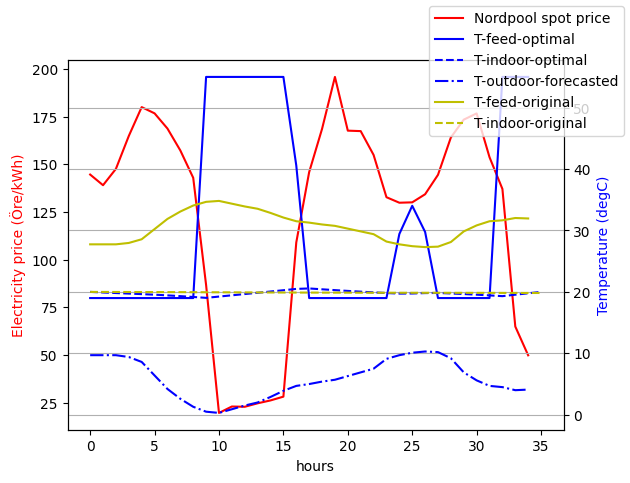

In [41]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices, "r", label="Nordpool spot price")
ax2.plot(res.x, "b-", label="T-feed-optimal")
ax2.plot(simulation(res.x), "b--", label="T-indoor-optimal")
ax2.plot(T_out, "b-.", label="T-outdoor-forecasted")
ax2.plot(T_fr_0, "y", label="T-feed-original")
ax2.plot(simulation(T_fr_0), "y--", label="T-indoor-original")

ax1.set_xlabel("hours")
ax1.set_ylabel("Electricity price (Öre/kWh)", color="r")
ax2.set_ylabel("Temperature (degC)", color="b")

fig.legend()
plt.grid()

In [42]:
print("Optimal framledningstemperatur just nu:", res.x[0], "degC")
print(
    "Styrsignal till VP (fejkad utetemperatur):",
    inverse_heating_curve(4.7, res.x[0]),
    "degC",
)
print("Besparing:", (1 - (res.x * prices).sum() / (T_fr_0 * prices).sum()) * 100, "%")

Optimal framledningstemperatur just nu: 19.0 degC
Styrsignal till VP (fejkad utetemperatur): 21.329787234042552 degC
Besparing: 18.05867244471483 %
